In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_california_housing
from sklearn.preprocessing import StandardScaler

In [3]:
data = fetch_california_housing()

df = pd.DataFrame(data.data, columns=data.feature_names)
df['target'] = data.target
df.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,target
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


In [5]:
scaler = StandardScaler()
df.values[:, :-1] = scaler.fit_transform(df.values[:, :-1])

df.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,target
0,2.344766,0.982143,0.628559,-0.153758,-0.974429,-0.049597,1.052548,-1.327835,4.526
1,2.332238,-0.607019,0.327041,-0.263336,0.861439,-0.092512,1.043185,-1.322844,3.585
2,1.782699,1.856182,1.155620,-0.049016,-0.820777,-0.025843,1.038503,-1.332827,3.521
3,0.932968,1.856182,0.156966,-0.049833,-0.766028,-0.050329,1.038503,-1.337818,3.413
4,-0.012881,1.856182,0.344711,-0.032906,-0.759847,-0.085616,1.038503,-1.337818,3.422


In [23]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

data = torch.from_numpy(df.values).float()

X = data[:, :-1]
y = data[:, -1:]

print(f'X Shape : {X.shape}\ny Shape : {y.shape}')

X Shape : torch.Size([20640, 8])
y Shape : torch.Size([20640, 1])


In [24]:
n_epochs = 4000
batch_size = 256
print_interval = 400

In [25]:
model = nn.Sequential(
    nn.Linear(X.size(-1), 6),
    nn.LeakyReLU(),
    nn.Linear(6, 5),
    nn.LeakyReLU(),
    nn.Linear(5, 4),
    nn.LeakyReLU(),
    nn.Linear(4, 3),
    nn.LeakyReLU(),
    nn.Linear(3, y.size(-1))
)
print(model)

Sequential(
  (0): Linear(in_features=8, out_features=6, bias=True)
  (1): LeakyReLU(negative_slope=0.01)
  (2): Linear(in_features=6, out_features=5, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=5, out_features=4, bias=True)
  (5): LeakyReLU(negative_slope=0.01)
  (6): Linear(in_features=4, out_features=3, bias=True)
  (7): LeakyReLU(negative_slope=0.01)
  (8): Linear(in_features=3, out_features=1, bias=True)
)


In [26]:
# Adam 학습률 필요없어.. p1, p2=> (beta1, beta2) / (momentum + adagrad)

optimizer = optim.Adam(model.parameters())

In [28]:
for i in range(n_epochs):
    # X 섞어..
    indices = torch.randperm(X.size(0))
    

    x_ = torch.index_select(X, dim=0, index=indices)
    y_ = torch.index_select(y, dim=0, index=indices)

    x_ = x_.split(batch_size, dim=0)
    y_ = y_.split(batch_size, dim=0)

    y_hat = []
    total_loss = 0

    for x_i, y_i in zip(x_, y_):
        y_hat_i = model(x_i)

        loss = F.mse_loss(y_hat_i, y_i)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss # float로 바꿔주는게 좋음 .... float(loss) memory 절약
        y_hat += [y_hat_i]

    total_loss = total_loss / len(x_)
    if (i + 1) % print_interval == 0:
        print('Epoch %d: loss=%.4e' %(i + 1, total_loss))

y_hat = torch.cat(y_hat, dim=0)
y = torch.cat(y_, dim=0)

## optimizer SGD -> Adam 바꾸니 성능 확실히 좋아짐

Epoch 400: loss=3.0077e-01
Epoch 800: loss=2.9534e-01
Epoch 1200: loss=2.8892e-01
Epoch 1600: loss=2.8679e-01
Epoch 2000: loss=2.8515e-01
Epoch 2400: loss=2.8293e-01
Epoch 2800: loss=2.8313e-01
Epoch 3200: loss=2.8258e-01
Epoch 3600: loss=2.8150e-01
Epoch 4000: loss=2.8201e-01


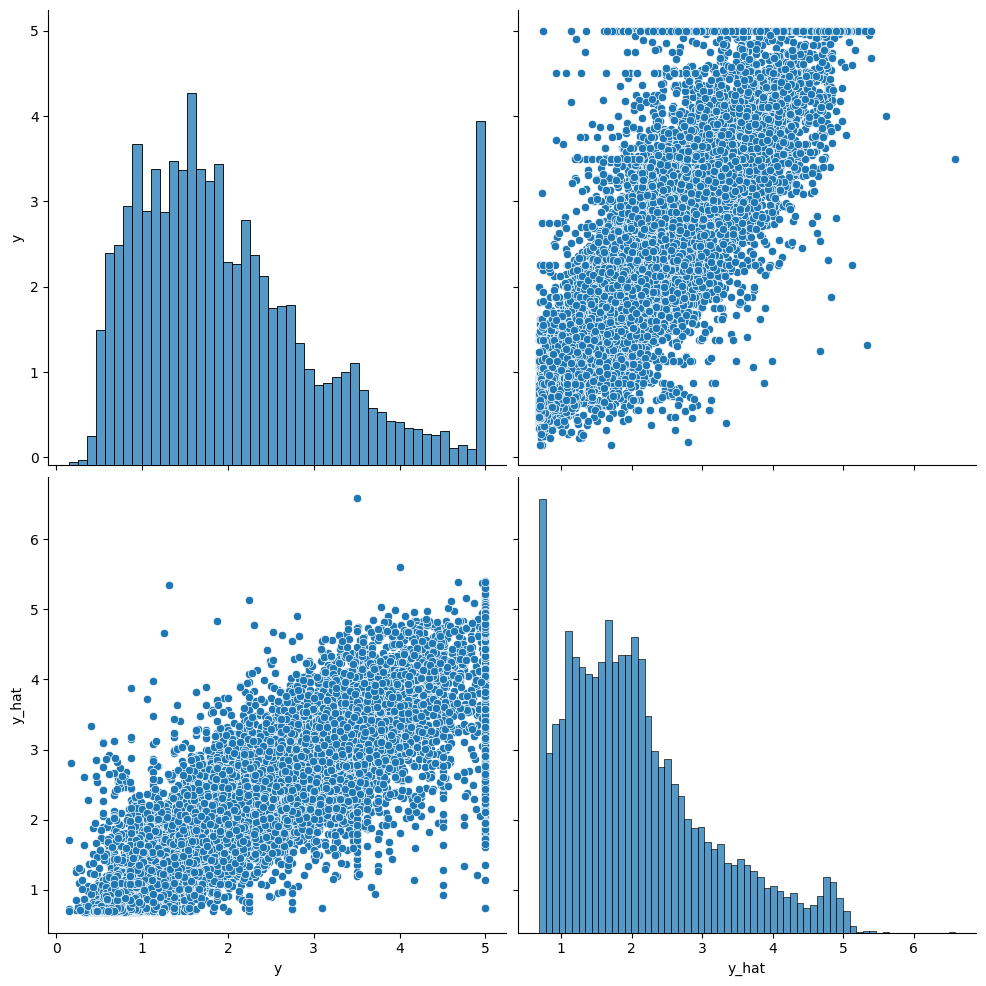

In [33]:
df = pd.DataFrame(torch.cat([y, y_hat], dim=1).detach().numpy(), columns=['y', 'y_hat'])

sns.pairplot(df, height=5)
plt.show()